`"Loading a dataset cached in a LocalFileSystem is not supported`. This bug probably stemed from the fsspec package error, as described in [Git issue](https://stackoverflow.com/questions/77433096/notimplementederror-loading-a-dataset-cached-in-a-localfilesystem-is-not-suppor).


In [ ]:
pip install fsspec==2023.9.2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 11.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requi

The orginal dataset faces some problems and can not de download through load_dataset() function. This [Git issue](https://github.com/huggingface/datasets/issues/3465) contain the solution.

In [ ]:
from datasets import load_dataset

dataset = load_dataset("ccdv/cnn_dailymail", version="3.0.0", download_mode="force_redownload")
print(f"Features: {dataset['train'].column_names}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Extracting data files:   0%|          | 0/5 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Features: ['article', 'highlights', 'id']


/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [ ]:
sample = dataset["train"][1]
print(f"Title: {sample['id']}")
print(f"Text length: {len(sample['article'])} \nText content:{sample['article'][:1000]}")
print(f"Summary length: {len(sample['highlights'])} \nSummary content: {sample['highlights']}")

Title: 0002095e55fcbd3a2f366d9bf92a95433dc305ef
Text length: 3192 
Text content:(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has now collected eight gold medals at world championships, equaling the record held by American trio Carl Lewis, Michael Johnson and Allyson Felix, not to mention the small matter of six Olympic titles. The relay triumph followed individual successes in the 100 and 200 meters in the Russian capital. "I'm proud of myself and I'll continue to work to dominate for as long as possible," Bolt said, having previously expressed

<h2>1. Text Summarization Pipelines</h2>

In [ ]:
#restrict the input size
sample_text = dataset["train"][1]["article"][:2000]
summaries = {}

In [ ]:
import nltk #Natural Language Toolkit
from nltk.tokenize import sent_tokenize

nltk.download("punkt")
nltk.download('punkt_tab')
#Test if sen_tokenize can accurately split the sentences without depending on ".".
string = "The U.S. are a country. The U.N. is an organization."
sent_tokenize(string)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


['The U.S. are a country.', 'The U.N. is an organization.']

<h3>1.1. Summarization Baseline</h3>

A standard and heuristic approach for summarization is take the first 3 sentences. We create the baseline following this approach.

In [ ]:
def three_sentence_baseline(text):
  return "\n".join(sent_tokenize(text)[:3])

In [ ]:
summaries["baseline"] = three_sentence_baseline(sample_text)
summaries

{'baseline': "(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay.\nThe fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds.\nThe U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover."}

<h3>a. GPT</h3>

In [ ]:
from transformers import pipeline, set_seed

In [ ]:
set_seed(42) # Set the seed to get reproducible results
pipe = pipeline("text-generation", model = 'gpt2')
gpt_query = sample_text +'\nTL;DR:\n'
pipe_out = pipe(gpt_query, max_length=512, clean_up_tokenization_spaces=True)

#slicing off the input query by [len(gpt_query):]
summaries["gpt"] = "\n".join(sent_tokenize(pipe_out[0]['generated_text'][len(gpt_query):]))
summaries

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=512) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


{'baseline': "(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay.\nThe fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds.\nThe U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover.",
 'gpt': "The U.S. men's Olympic team had the most medals held by any men's team in the 200 meters on the field, with the most gold in the 400 and 400m on the field.\nThe women's team of the day had the most medals held by any women's team in the 200 meters.\nThe U.S. men's team of the day had the most medals held by any men's team in the 400 and 400m on the field."}

<h3>b. T5-small

T5 is a universal transformer architecture by formulating all tasks as text-totext tasks. The T5 checkpoints are trained on a mixture of unsupervised data (to reconstruct masked words) and supervised data for several tasks, including summarization.

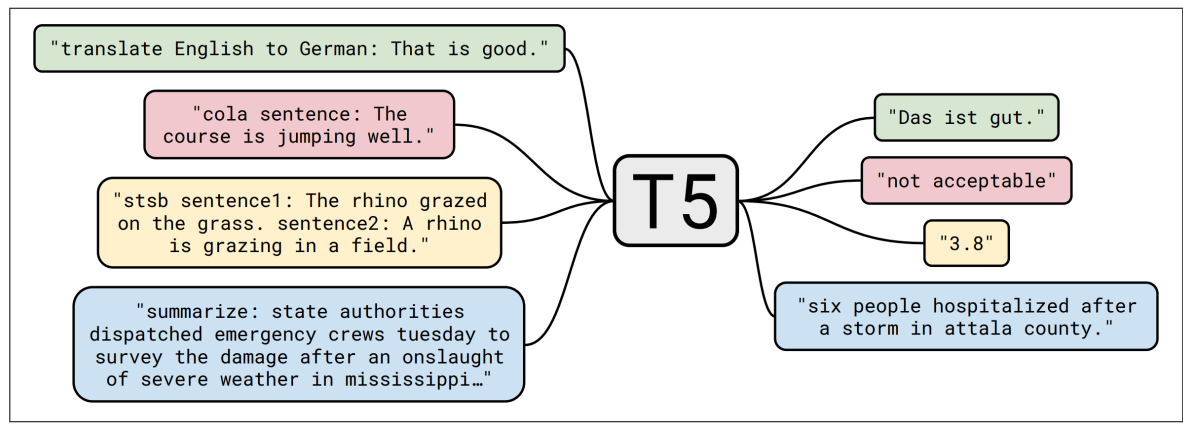

In [ ]:
pipe = pipeline("summarization", model = 't5-small')
pipe_out = pipe(sample_text)
summaries["t5"] = "\n".join(sent_tokenize(pipe_out[0]['summary_text']))
summaries

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Device set to use cuda:0


{'baseline': "(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay.\nThe fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds.\nThe U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover.",
 'gpt': "The U.S. men's Olympic team had the most medals held by any men's team in the 200 meters on the field, with the most gold in the 400 and 400m on the field.\nThe women's team of the day had the most medals held by any women's team in the 200 meters.\nThe U.S. men's team of the day had the most medals held by any men's team in the 400 and 400m on the field.",
 't5': "usain Bolt wins men's 4x100m relay gold in Moscow .\nthe fastest man in the world wins in 37.36 seconds .\ncanada takes bronze afte

<h3>c. BART </h3>

In [ ]:
pipe = pipeline("summarization", model = 'facebook/bart-large-cnn')
pipe_out = pipe(sample_text)
summaries['bart'] = "\n".join(sent_tokenize(pipe_out[0]['summary_text']))
summaries

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


{'baseline': "(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay.\nThe fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds.\nThe U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover.",
 'gpt': "The U.S. men's Olympic team had the most medals held by any men's team in the 200 meters on the field, with the most gold in the 400 and 400m on the field.\nThe women's team of the day had the most medals held by any women's team in the 200 meters.\nThe U.S. men's team of the day had the most medals held by any men's team in the 400 and 400m on the field.",
 't5': "usain Bolt wins men's 4x100m relay gold in Moscow .\nthe fastest man in the world wins in 37.36 seconds .\ncanada takes bronze afte

<h3>d. Pegasus

In [ ]:
pipe = pipeline("summarization", model = 'google/pegasus-cnn_dailymail')
pipe_out = pipe(sample_text)
summaries["pegasus"] = pipe_out[0]['summary_text'].replace(" .<n>", ".\n")

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0


<h2>2. Comparing Different Summaries


In [ ]:
print("GROUND TRUTH")
print(dataset["train"][1]["highlights"])
print("")

for model_name in summaries:
  print(model_name.upper())
  print(summaries[model_name])
  print("")

GROUND TRUTH
Usain Bolt wins third gold of world championship .
Anchors Jamaica to 4x100m relay victory .
Eighth gold at the championships for Bolt .
Jamaica double up in women's 4x100m relay .

BASELINE
(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay.
The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds.
The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover.

GPT
The U.S. men's Olympic team had the most medals held by any men's team in the 200 meters on the field, with the most gold in the 400 and 400m on the field.
The women's team of the day had the most medals held by any women's team in the 200 meters.
The U.S. men's team of the day had the most medals held by any men's 

In [ ]:
!pip install sacrebleu
from datasets import load_metric
bleu_metric = load_metric("sacrebleu")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 9.9 MB/s eta 0:00:00


<ipython-input-14-1560001239>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric("sacrebleu")


In [ ]:
import pandas as pd
import numpy as np

bleu_metric.add(
    predictions = "the the the the the the",
    references = ['the cat is on the mat']
)
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results['precisions'] = [np.round(p, 2) for p in results['precisions']]
pd.DataFrame.from_dict(results, orient = 'index', columns = ['Value'])

,Value
score,0.0
counts,"[2, 0, 0, 0]"
totals,"[6, 5, 4, 3]"
precisions,"[33.33, 0.0, 0.0, 0.0]"
bp,1.0
sys_len,6
ref_len,6


the `precisions []` arguement show the n-grams precision: in 1-grams: precision = 2/6, and the rest in 0.

In [ ]:
bleu_metric.add(
    predictions = "the cat is on mat",
    references = ['the cat is on the mat']
)
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results['precisions'] = [np.round(p, 2) for p in results['precisions']]
pd.DataFrame.from_dict(results, orient = 'index', columns = ['Value'])

,Value
score,57.893007
counts,"[5, 3, 2, 1]"
totals,"[5, 4, 3, 2]"
precisions,"[100.0, 75.0, 66.67, 50.0]"
bp,0.818731
sys_len,5
ref_len,6


In [ ]:
!pip install rouge_score
rouge_metric = load_metric('rouge')

apply the ROUGE score to all the models' summaries

In [ ]:
references = dataset["train"][1]["highlights"]
record = []
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
for model_name in summaries:
  rouge_metric.add(prediction = summaries[model_name], reference = references)
  score = rouge_metric.compute()
  rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
  record.append(rouge_dict)
pd.DataFrame.from_records(record, index = summaries.keys())

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.303571,0.090909,0.214286,0.232143
gpt,0.106195,0.018018,0.088496,0.106195
t5,0.366667,0.137931,0.266667,0.333333
bart,0.582278,0.207792,0.455696,0.506329


<h1>3. Evaluating PEGASUS on the CNN/DailyMail Dataset


In [ ]:
def evaluate_summaries_baseline(dataset, metric, column_text = "article", column_summary = "highlights"):
  summaries = [three_sentence_baseline(text) for text in dataset[column_text]]
  metric.add_batch(predictions = summaries,
                   references = dataset[column_summary])
  score = metric.compute()
  return score

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
#down-sample to minimize the calculation time
test_sample = dataset['test'].shuffle(seed = 42).select(range(200))

score = evaluate_summaries_baseline(test_sample, rouge_metric)

rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict, orient = 'index', columns = ['baseline']).T

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.39322,0.17789,0.254918,0.363329


In [ ]:
from tqdm import tqdm
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

#create batch_size chunks for multiple-processing
def chunks(list_of_elements, batch_size):
  """Yield successive batch-sized chunks from list_of_elements."""
  for i in range(0, len(list_of_elements), batch_size):
    yield list_of_elements[i: i + batch_size]


def evaluate_summaries_pegasus(dataset, metric, model, tokenizer,
                               batch_size = 16, device = device, column_text = "article", column_summary = "highlights"):
  article_batches = list(chunks(dataset[column_text], batch_size))
  target_batches = list(chunks(dataset[column_summary], batch_size))

  for article_batch, target_batch in tqdm(
      zip(article_batches, target_batches), total = len(article_batches)):
      inputs = tokenizer(article_batch, max_length = 1024, truncation = True, padding = "max_length", return_tensors = "pt")
      summaries = model.generate(input_ids = inputs["input_ids"].to(device),
                                 attention_mask = inputs["attention_mask"].to(device),
                                 length_penalty = 0.8, num_beams = 8, max_length = 128)
      decoded_summaries = [tokenizer.decode(s, skip_special_tokens = True, clean_up_tokenization_spaces = True)
                           for s in summaries]
      decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]
      metric.add_batch(predictions = decoded_summaries, references = target_batch)
  score = metric.compute()
  return score

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)
score = evaluate_summaries_pegasus(dataset = test_sample, metric = rouge_metric, model = model, tokenizer = tokenizer, batch_size = 4)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict, orient = 'index', columns = ['pegasus'])

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 50/50 [08:16<00:00,  9.92s/it]


,pegasus
rouge1,0.428488
rouge2,0.205761
rougeL,0.298884
rougeLsum,0.372259


In [ ]:
import torch
torch.cuda.empty_cache()
